In [1]:
### Loads in modules for this script 
import warnings
warnings.filterwarnings('ignore')
import datetime
from concurrent import futures
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pandas import DataFrame
from matplotlib.dates import date2num
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
import pylab
from datetime import datetime
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()
import os
import mpl_finance # this is needed for candle stick plots
import seaborn as sns


### Pulling S&P index to compare with shares later

In [ ]:
def download_stock(stock):
    """ try to query the iex for a stock, if failed note with print """
    try:
        print(stock)
        stock_df = pdr.get_data_yahoo(stock, start_time, now_time)
        stock_df['Name'] = stock
#         stock_df.columns = [str(col)]
        output_name = stock + '_data.csv'
        stock_df.to_csv(output_name)
    except:
        bad_names.append(stock)
        print('bad: %s' % (stock))
        
if __name__ == '__main__':

    """ set the download window """
    now_time = datetime(2017,12,29)
    start_time = datetime(2006,1,3)

    """ list of s_and_p companies """
    s_and_p = ['^GSPC']

    bad_names =[] #to keep track of failed queries

    """here we use the concurrent.futures module's ThreadPoolExecutor
        to speed up the downloads buy doing them in parallel 
        as opposed to sequentially """

    #set the maximum thread number
    max_workers = 1

    workers = min(max_workers, len(s_and_p)) #in case a smaller number of stocks than threads was passed in
    with futures.ThreadPoolExecutor(workers) as executor:
        res = executor.map(download_stock, s_and_p)


    """ Save failed queries to a text file to retry """
    if len(bad_names) > 0:
        with open('failed_queries.txt','w') as outfile:
            for name in bad_names:
                outfile.write(name+'\n')

    #timing:
    finish_time = datetime.now()
    duration = finish_time - now_time
    minutes, seconds = divmod(duration.seconds, 60)
    print('getSandP_threaded.py')
    print(f'The threaded script took {minutes} minutes and {seconds} seconds to run.')

## Mid Term

### Question 1. Load in all stock tickers as variables with the ticker symbol as their variable name, including the all stock csv file


### Question 1 Report

- We will start with a list of all csv files in the desired folder and store it in a python list
```python
path = os.path.join(os.getcwd(),'stock-time-series-20050101-to-20171231 (1)')
files_in_dir = [f for f in os.listdir(path) if f.endswith('csv')]
```
- Loop through the ticker names in the list and dynamically import all the csv with the ticker as the dataframe name
```python
for filenames in files_in_dir:
    name = filenames.split(sep='_')[0]
    exec('{} = pd.read_csv(os.path.join(os.getcwd(),\'stock-time-series-20050101-to-20171231 (1)\',filenames))'.format(name))
```

### Question 1 Analysis

In [2]:
# extract the list of files in the target folder
# path = 'C:\\Users\\sahH\\Downloads\\BUAN 6340\\BUAN 6340\\BUAN 6340\\Mid Term\\stock-time-series-20050101-to-20171231 (1)'
path = os.path.join(os.getcwd(),'stock-time-series-20050101-to-20171231 (1)')
files_in_dir = [f for f in os.listdir(path) if f.endswith('csv')]

In [3]:

for filenames in files_in_dir:
    name = filenames.split(sep='_')[0]
    exec('{} = pd.read_csv(os.path.join(os.getcwd(),\'stock-time-series-20050101-to-20171231 (1)\',filenames))'.format(name))

### Question 2. Perform Exploratory data analysis and data visualization for different time periods using given stock dataset

### Question 2 Approach

## Question 2 Analysis 

In [4]:
# Extracting year from the timeseries date index
all.Date = pd.to_datetime(all.Date)
all['year'] = all.Date.dt.year

C:\Users\sahH\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


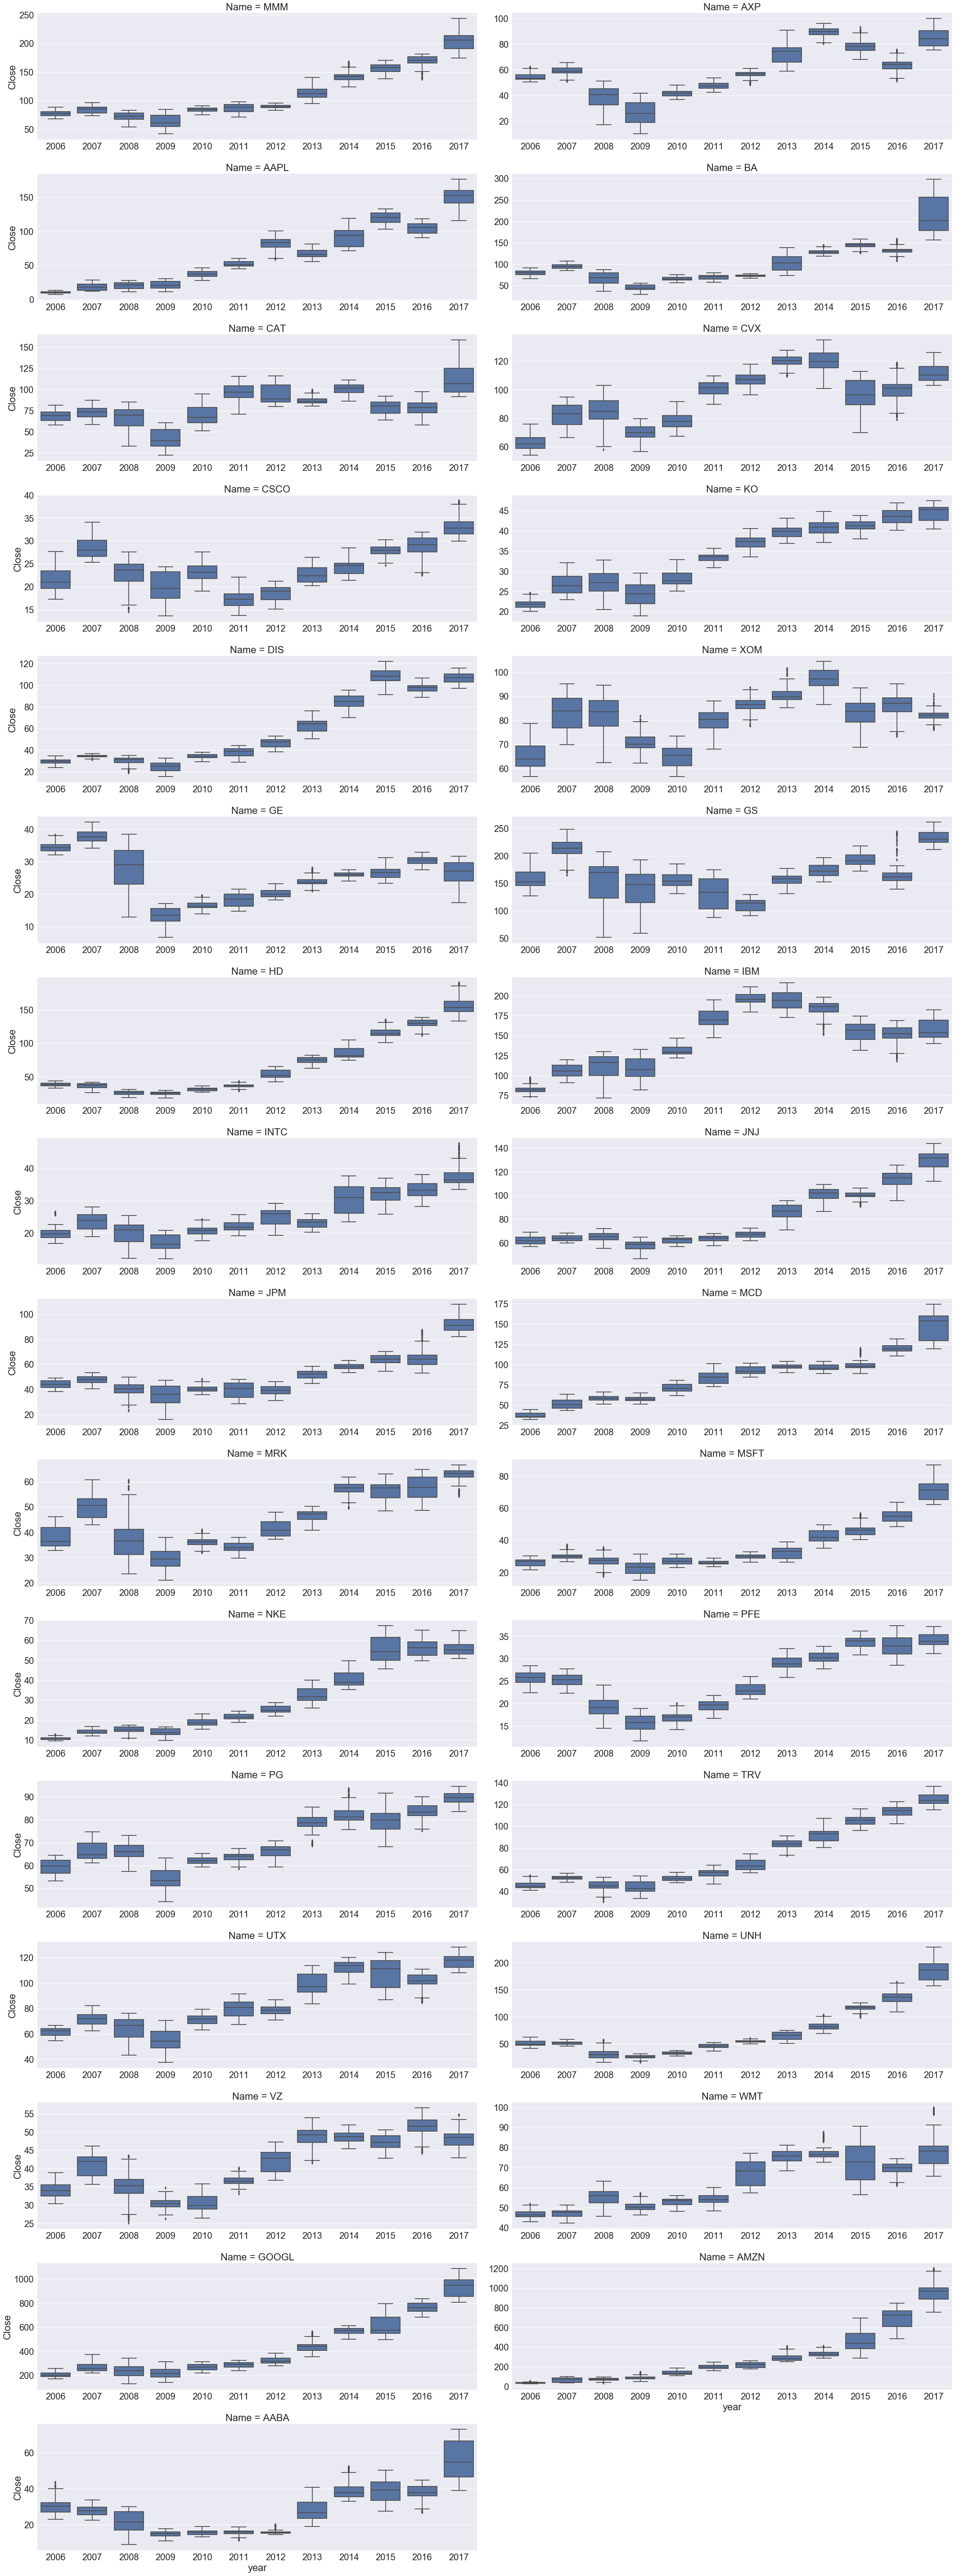

In [5]:
# Seaborn facetgrid for analysis yearly trends for the shares
sns.set(font_scale=2)
grid = sns.FacetGrid(all, col="Name", col_wrap=2,sharex = False,sharey=False,aspect= 3,size = 5 )
grid.set_titles('Trends of closing shares across years')
grid.map(sns.boxplot,'year','Close')


In [6]:
# higest earning stock and highest lossing stock in each year
#using pct_change() to calulate daily and then convert it to yearly sales

all['performance'] = all.groupby(['Name','year']).Close.apply(lambda x: x.pct_change())
YearReturn = all.groupby(['Name','year'])['performance'].mean().reset_index().assign(yRet = lambda x : x.performance * 250)
YearReturn['ToPRank'] = YearReturn.groupby('year')['yRet'].rank(method = 'min',ascending = False)
YearReturn['BotRank'] = YearReturn.groupby('year')['yRet'].rank(method = 'min',ascending = True)

#High traded stocks in terms of volume
HighTraded = all.groupby(['Name','year'])['Volume'].sum().reset_index()
HighTraded['Rank']=HighTraded.groupby('year')['Volume'].rank(method = 'min',ascending = True)


In [7]:
# filter top 10 return yearly
TopReturn = YearReturn[YearReturn['ToPRank'] <=10].pivot(index = 'ToPRank',columns='year', values='Name')
TopReturn

year,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
ToPRank,,,,,,,,,,,,
1.0,CSCO,AMZN,WMT,AMZN,CAT,UNH,HD,AABA,INTC,AMZN,CAT,BA
2.0,GS,AAPL,MCD,AXP,AAPL,MCD,AMZN,BA,AAPL,GOOGL,GS,AABA
3.0,DIS,GOOGL,TRV,AAPL,AMZN,IBM,GS,AMZN,UNH,NKE,UNH,CAT
4.0,MRK,MCD,JPM,GS,NKE,AAPL,AAPL,GOOGL,AABA,HD,JPM,AMZN
5.0,MCD,INTC,HD,GOOGL,HD,PFE,DIS,AXP,HD,MCD,CVX,AAPL
6.0,XOM,MRK,XOM,JPM,MCD,HD,JPM,NKE,CSCO,GE,AABA,WMT
7.0,BA,CVX,JNJ,MSFT,GE,INTC,AABA,DIS,MSFT,MSFT,IBM,MCD
8.0,CVX,NKE,CVX,IBM,BA,CVX,TRV,MMM,NKE,UNH,MMM,HD
9.0,VZ,XOM,NKE,CSCO,DIS,XOM,AXP,UNH,DIS,DIS,AMZN,MSFT


In [8]:
BotReturn = YearReturn[YearReturn['BotRank'] <=10].pivot(index = 'BotRank',columns='year', values='Name')
BotReturn

year,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
BotRank,,,,,,,,,,,,
1.0,AABA,HD,AXP,XOM,CSCO,GS,INTC,IBM,AMZN,AABA,NKE,GE
2.0,INTC,PFE,GE,WMT,MSFT,JPM,MCD,CAT,IBM,WMT,KO,XOM
3.0,AMZN,AXP,AAPL,VZ,PFE,CSCO,CAT,AAPL,CVX,CAT,DIS,IBM
4.0,UNH,JPM,GOOGL,PG,JNJ,MSFT,CVX,MCD,GE,AXP,PFE,MRK
5.0,HD,DIS,GS,MCD,GOOGL,UTX,XOM,KO,XOM,CVX,HD,VZ
6.0,MMM,AABA,BA,GE,MRK,MMM,MSFT,VZ,VZ,UTX,GE,DIS
7.0,WMT,GE,MRK,PFE,WMT,AMZN,PG,CSCO,BA,XOM,MCD,CVX
8.0,GE,BA,UNH,CVX,AABA,GE,BA,CVX,GOOGL,IBM,GOOGL,GS
9.0,JNJ,JNJ,MSFT,JNJ,GS,CAT,IBM,WMT,MCD,PG,PG,PG


In [9]:
HighStocks = HighTraded[HighTraded['Rank'] <=10].pivot(index = 'Rank', columns = 'year',values = 'Name')
HighStocks

year,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Rank,,,,,,,,,,,,
1.0,TRV,TRV,TRV,GOOGL,GOOGL,GOOGL,GOOGL,TRV,GOOGL,TRV,TRV,TRV
2.0,MMM,MMM,MMM,MMM,MMM,MMM,TRV,GOOGL,TRV,GOOGL,GOOGL,GOOGL
3.0,UTX,UTX,GOOGL,UTX,TRV,TRV,MMM,MMM,MMM,MMM,MMM,MMM
4.0,BA,BA,UTX,TRV,UTX,UTX,IBM,AMZN,GS,GS,UNH,UTX
5.0,GS,GOOGL,BA,BA,BA,BA,UTX,UTX,UTX,AMZN,GS,UNH
6.0,AXP,CAT,CAT,IBM,IBM,IBM,AMZN,GS,AXP,BA,IBM,GS
7.0,CAT,AXP,IBM,AMZN,MCD,AMZN,BA,IBM,AMZN,UNH,AMZN,BA
8.0,IBM,MCD,AMZN,MCD,AMZN,GS,GS,AXP,UNH,IBM,UTX,MCD
9.0,AMZN,UNH,MCD,CVX,CAT,MCD,AXP,MCD,BA,UTX,BA,AMZN


In [10]:
# Removing multiindex from the pivot operation and calulating the correlation matrix
all_pivot = all.reset_index().pivot(index = 'Date',columns = 'Name',values = 'Close')
all_pivot = all_pivot.rename_axis(None,axis=1).reset_index()
all_pivot['Date'] = pd.to_datetime(all_pivot.Date)
# Stockfive = Stockfive.set_index('Date')
corr = all_pivot.corr()

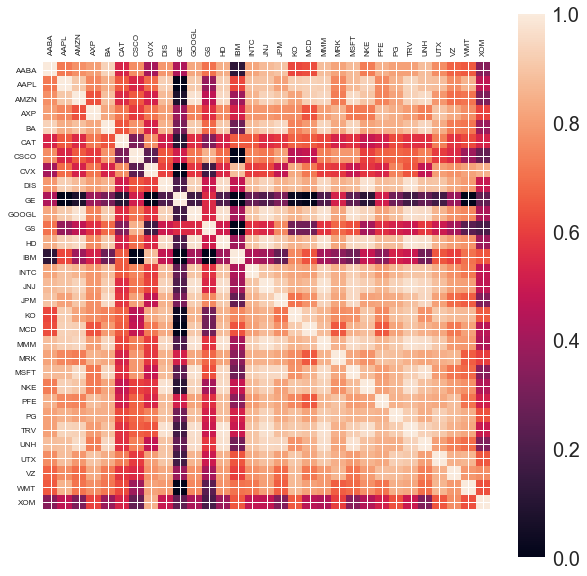

In [11]:
# Analysisng the correlation between the various stocks
fig, ax = plt.subplots(figsize=(10, 10))
heat = ax.matshow(corr, vmin=0,vmax=1,interpolation='nearest')
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical', fontsize=8);
plt.yticks(range(len(corr.columns)), corr.columns, fontsize=8)
plt.colorbar(heat)

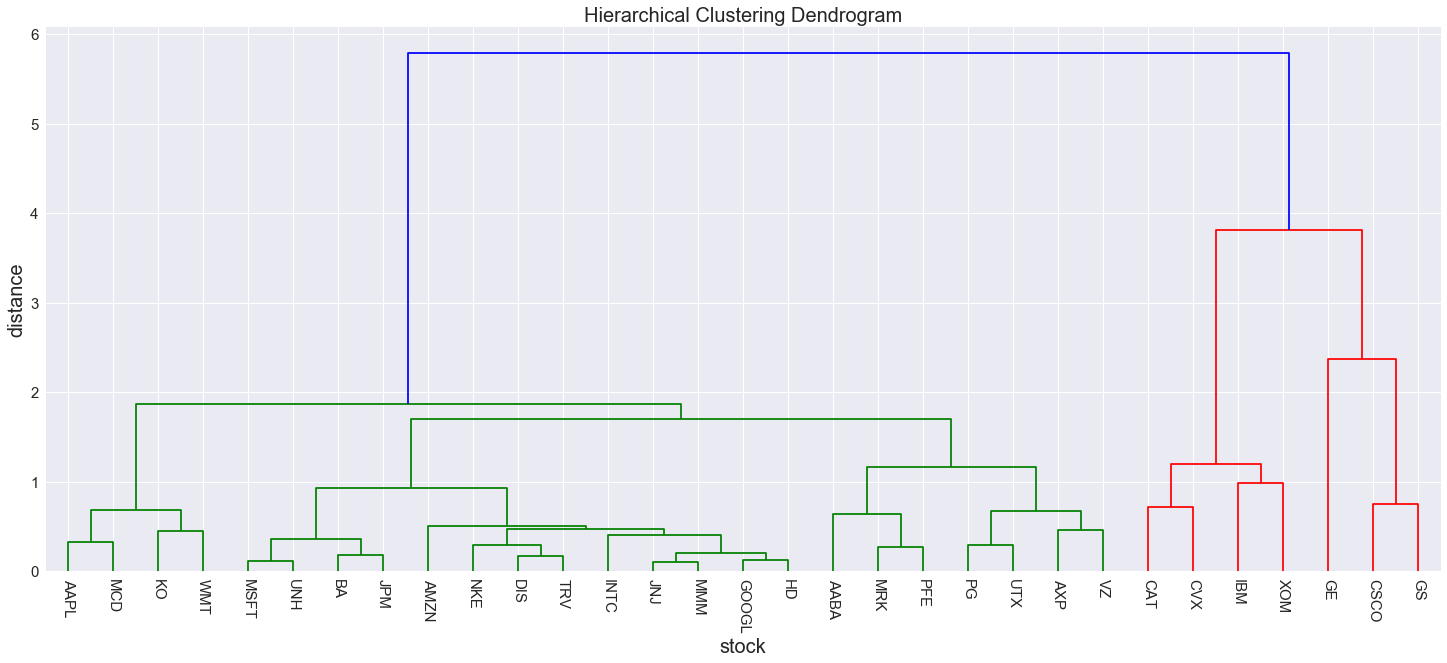

In [12]:
# Clusters of Correlation - Agglomerate

Z = linkage(corr, 'ward')
c, coph_dists = cophenet(Z, pdist(corr))
plt.figure(figsize=(25, 10))
labelsize=20
ticksize=15
plt.title('Hierarchical Clustering Dendrogram', fontsize=labelsize)
plt.xlabel('stock', fontsize=labelsize)
plt.ylabel('distance', fontsize=labelsize)
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    labels = corr.columns
)
pylab.yticks(fontsize=ticksize)
pylab.xticks(rotation=-90, fontsize=ticksize)
# plt.savefig('img/dendogram_'+index+'.png')
plt.show()

# Question 3

## Question 3.You need to take one stock and perform descriptive analysis  (Min, Max, explore some moving averages over the time) and Compare two stock’s descriptive analysis

## Question 3 Report

## Question 3 Analysis

In [13]:

#importing overall market data
SPY = pd.read_csv('^GSPC_data.csv')
# print(SPY.columns)
SPY.Date = pd.to_datetime(SPY.Date)
SPY = SPY.set_index('Date')

In [14]:
# setting time series index
AAPL.Date = pd.to_datetime(AAPL.Date)
AAPL = AAPL.set_index('Date')
AMZN.Date = pd.to_datetime(AMZN.Date)
AMZN = AMZN.set_index('Date')
# MSFT.Date = pd.to_datetime(MSFT.Date)
# MSFT = MSFT.set_index('Date')


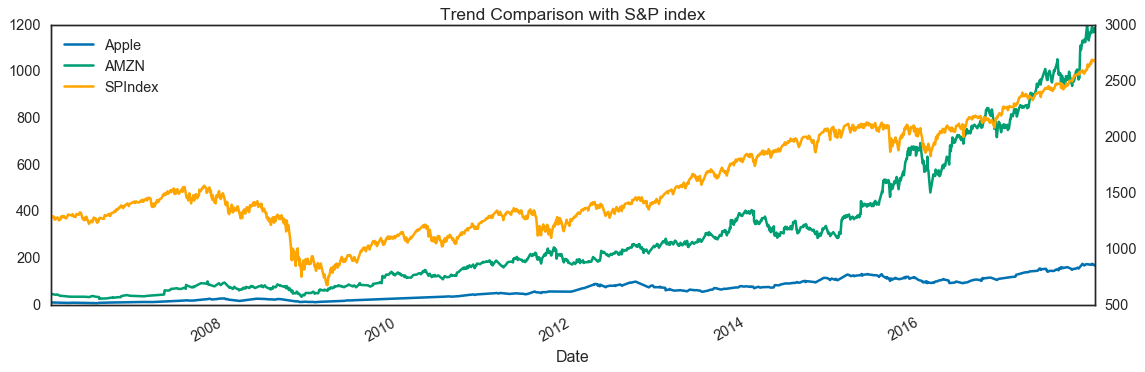

In [116]:
plt.style.use('seaborn-white')
fig = plt.figure(figsize=(15, 5))
plt.title('Trend Comparison with S&P index')
AAPL['Close'].plot(label = 'Apple')
AMZN['Close'].plot(label = 'AMZN')
SPY['Close'].plot(label = 'SPIndex',secondary_y = True,color='orange')
# creating handles for legends
handles,labels = [],[]
for ax in fig.axes:
    for h,l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)

plt.legend(handles,labels,loc = 2)

In [159]:
AMZN.describe()

,Open,High,Low,Close,Volume
count,3019.000000,3019.000000,3019.000000,3019.000000,3.019000e+03
mean,299.335310,302.371163,296.037695,299.376231,5.931712e+06
std,280.120547,281.826442,277.927134,279.980161,5.122034e+06
min,26.090000,26.300000,25.760000,26.070000,9.864350e+05
25%,81.175000,82.580000,79.725000,81.090000,3.137037e+06
50%,205.330000,208.000000,202.100000,205.440000,4.724100e+06
75%,375.570000,379.155000,373.000000,375.140000,7.135246e+06
max,1204.880000,1213.410000,1191.150000,1195.830000,1.044046e+08


In [160]:
AAPL.describe()

,Open,High,Low,Close,Volume
count,3019.000000,3019.000000,3019.000000,3019.000000,3.019000e+03
mean,64.673309,65.256833,64.033445,64.662892,1.311457e+08
std,44.524927,44.811772,44.230829,44.536448,1.018560e+08
min,7.390000,7.560000,7.170000,7.240000,1.147592e+07
25%,23.425000,23.805000,23.015000,23.420000,5.292889e+07
50%,57.860000,58.460000,57.320000,57.920000,1.066271e+08
75%,99.165000,100.275000,98.385000,99.480000,1.798977e+08
max,175.110000,177.200000,174.860000,176.420000,8.432640e+08


C:\Users\sahH\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\sahH\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\sahH\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\sahH\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is dep

Text(0.5,1,'Apple closing shares')

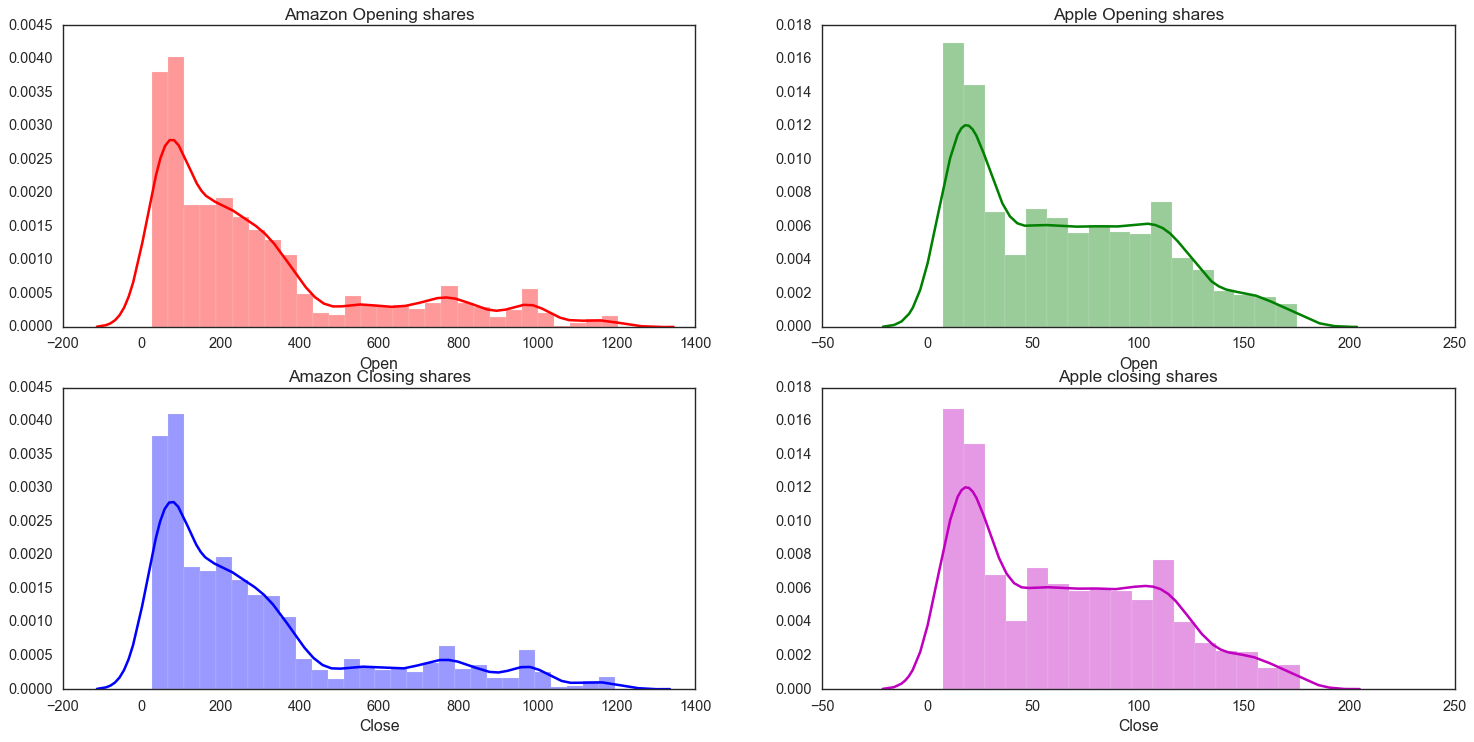

In [68]:
# dist plot for close and open shares
fig, axes = plt.subplots(2,2,figsize=(20, 10))

sns.distplot(AMZN['Open'],ax = axes[0,0],color='r').set_title('Amazon Opening shares')
sns.distplot(AAPL['Open'],ax=axes[0,1],color='g').set_title('Apple Opening shares')
sns.distplot(AMZN['Close'],ax = axes[1,0],color='b').set_title('Amazon Closing shares')
sns.distplot(AAPL['Close'],ax=axes[1,1],color='m').set_title('Apple closing shares')


In [69]:
#defining candle stick funciton 
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
# import mpl_finance
# from mpl_finance import candlestick_ohlc
 
def pandas_candlestick_ohlc(dat,fig,ax, stick = "day", adj = False, otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param adj: A boolean indicating whether to use adjusted prices
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    fields = ["Open", "High", "Low", "Close"]
    if adj:
        fields = ["Adj. " + s for s in fields]
    transdat = dat.loc[:,fields]
    transdat.columns = pd.Index(["Open", "High", "Low", "Close"])
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 

    # Set plot parameters, including the axis object ax used for plotting
#     fig, ax = plt.subplots(figsize = (15,7))
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
#         ax.xaxis.set_major_locator(mondays)
#         ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    mpl_finance.candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
#     plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
#     fig, ax = plt.subplots(figsize=(15, 5))
    return ax

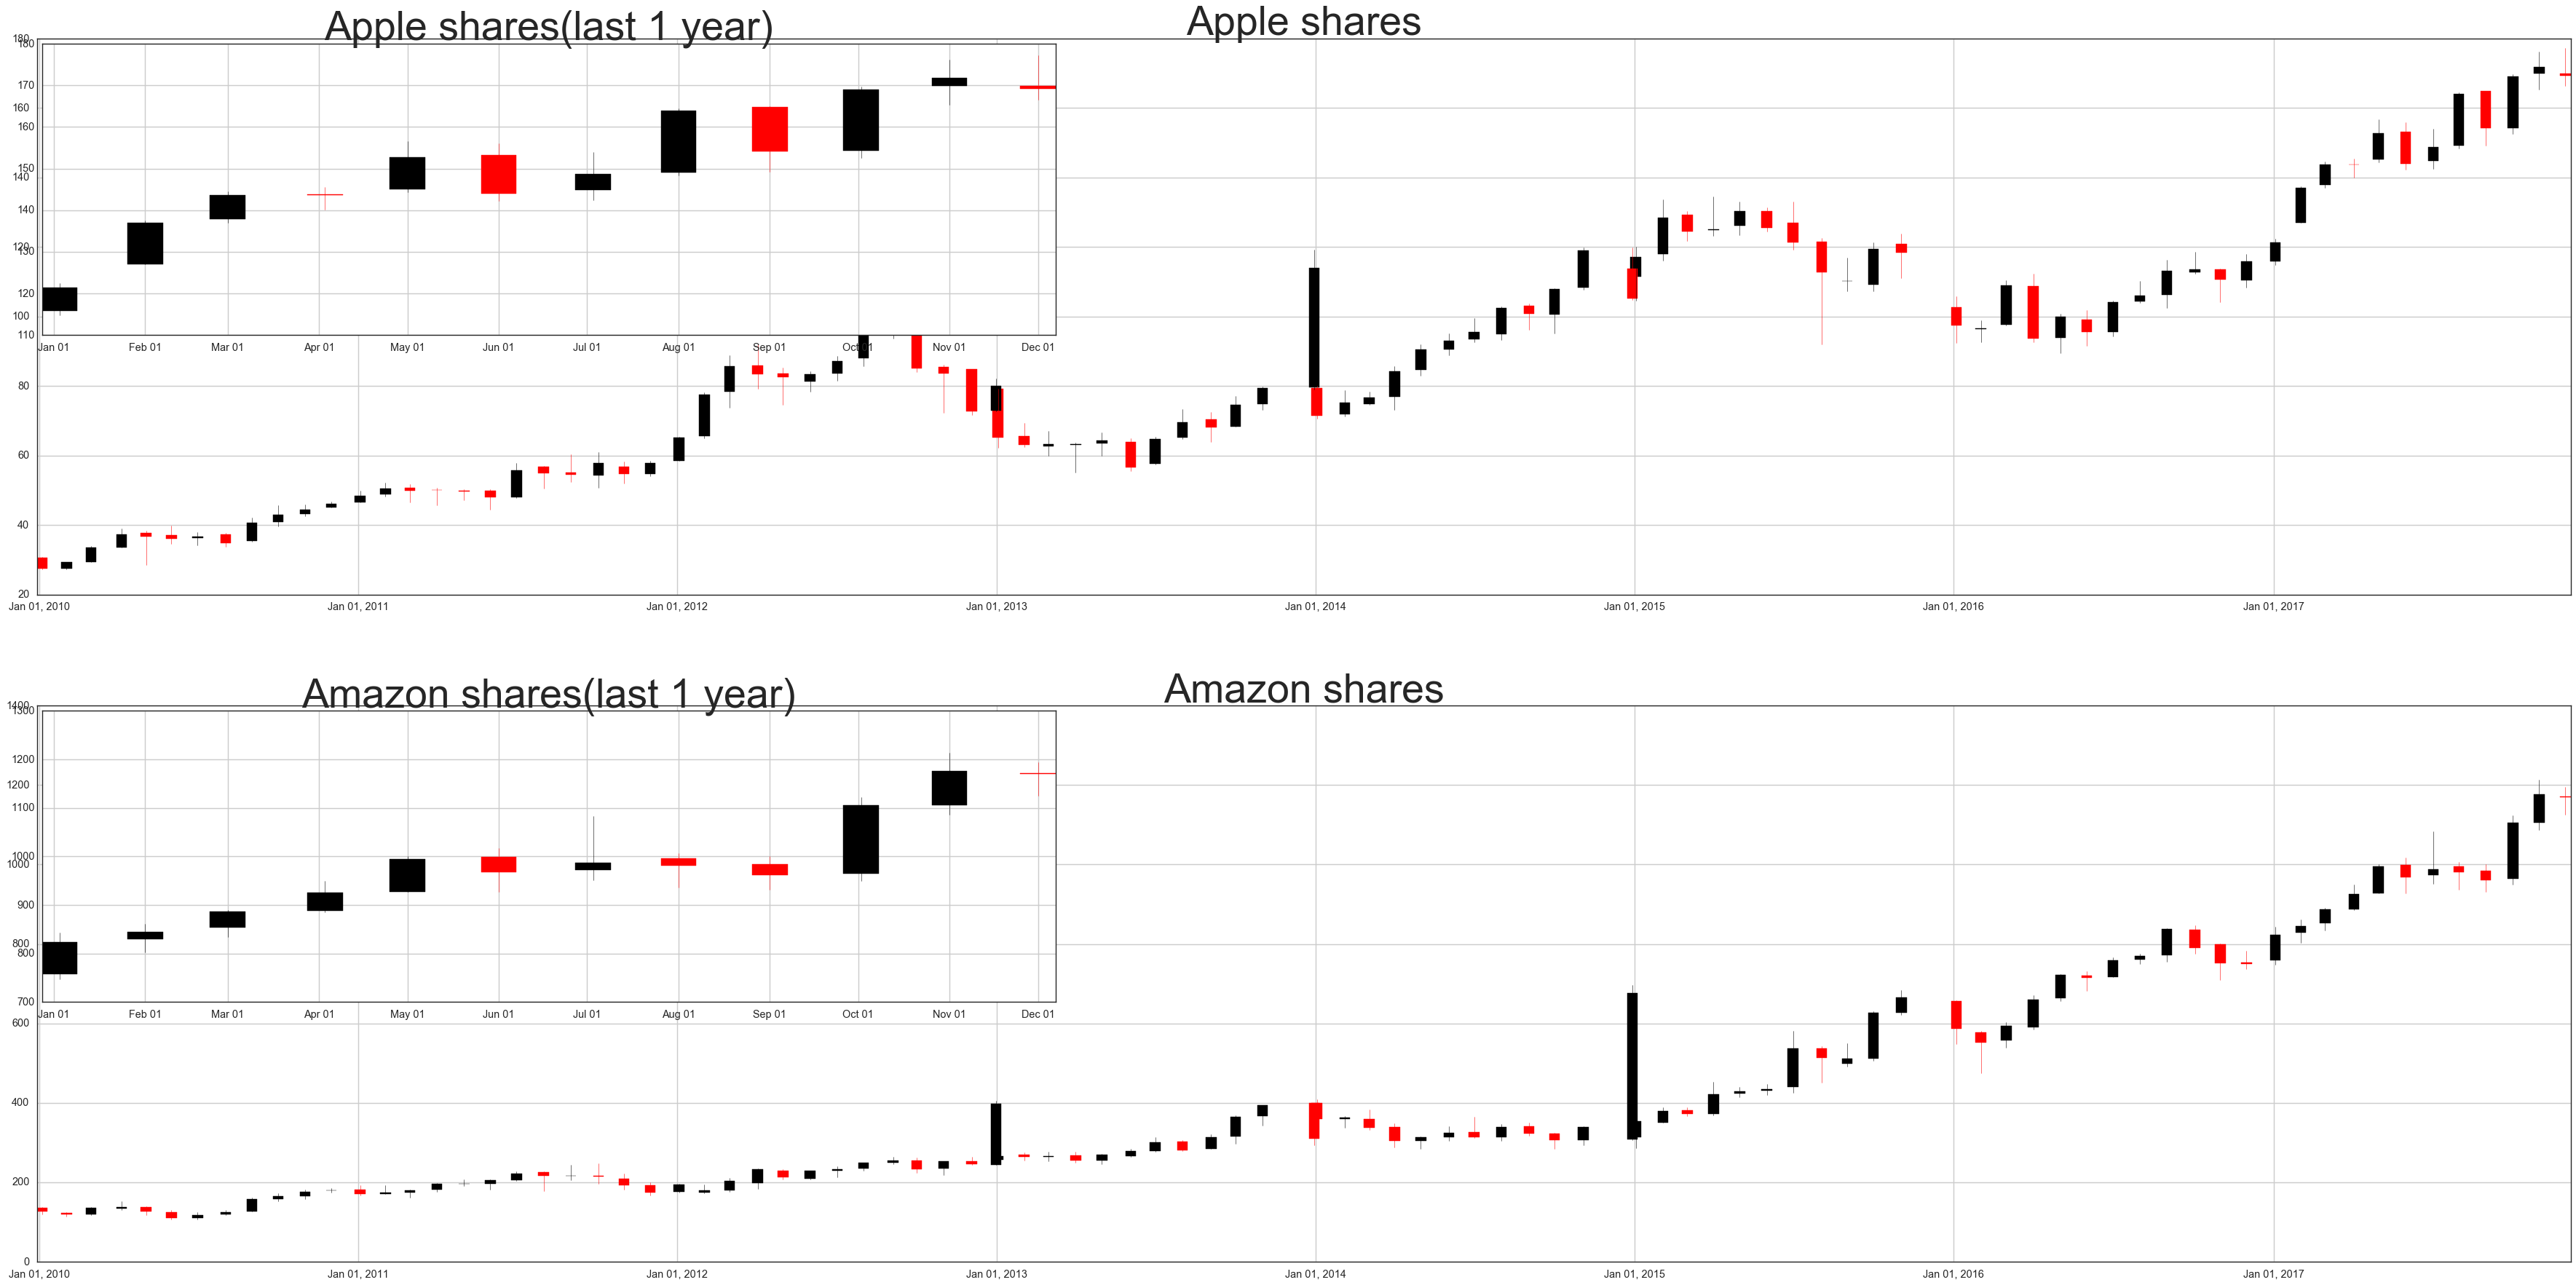

In [70]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(50, 30))
# plt.subplots(figsize=(15, 5))
# figure(1)
# subplot(2,1,1)
# inset_ax = fig.add_axes([0.2, 0.35, 0.3, 0.2])/
inset_am = inset_axes(ax2, 
                    width="40%", # width = 30% of parent_bbox
                    height=5, # height : 1 inch
                    loc='upper left')
#                      label = 'Last 1 year')
inset_ap = inset_axes(ax1, 
                    width="40%", # width = 30% of parent_bbox
                    height=5, # height : 1 inch
                    loc='upper left')

ax1.set_title('Apple shares',fontsize = 50)
ax2.set_title('Amazon shares',fontsize = 50)
inset_am.set_title('Amazon shares(last 1 year)',fontsize = 50)
inset_ap.set_title('Apple shares(last 1 year)',fontsize = 50)

# ax2.title.set_text('Amazon Share',fontsize=15)
ax = pandas_candlestick_ohlc(AAPL.loc['2010-01-01':,],fig=fig,ax=ax1,adj=False, stick="month")
ax = pandas_candlestick_ohlc(AAPL.loc['2017-01-01':,],fig=fig,ax=inset_ap,adj=False, stick="month")

ax = pandas_candlestick_ohlc(AMZN.loc['2010-01-01':,],fig=fig,ax=ax2,adj=False, stick="month")
ax = pandas_candlestick_ohlc(AMZN.loc['2017-01-01':,],fig=fig,ax=inset_am,adj=False, stick="month")

# plt.legend()
# plt.show()

## Moving Averages to get the trend

In [40]:
# Calculating moving averages for apple share
AAPL["20d"] = np.round(AAPL["Close"].rolling(window = 20, center = False).mean(), 2)
AAPL["50d"] = np.round(AAPL["Close"].rolling(window = 50, center = False).mean(), 2)
AAPL["100d"] = np.round(AAPL["Close"].rolling(window = 100, center = False).mean(), 2)
AAPL["200d"] = np.round(AAPL["Close"].rolling(window = 200, center = False).mean(), 2)

In [41]:
# Calculating moving averages for amazon
AMZN["20d"] = np.round(AMZN["Close"].rolling(window = 20, center = False).mean(), 2)
AMZN["50d"] = np.round(AMZN["Close"].rolling(window = 50, center = False).mean(), 2)
AMZN["100d"] = np.round(AMZN["Close"].rolling(window = 100, center = False).mean(), 2)
AMZN["200d"] = np.round(AMZN["Close"].rolling(window = 200, center = False).mean(), 2)

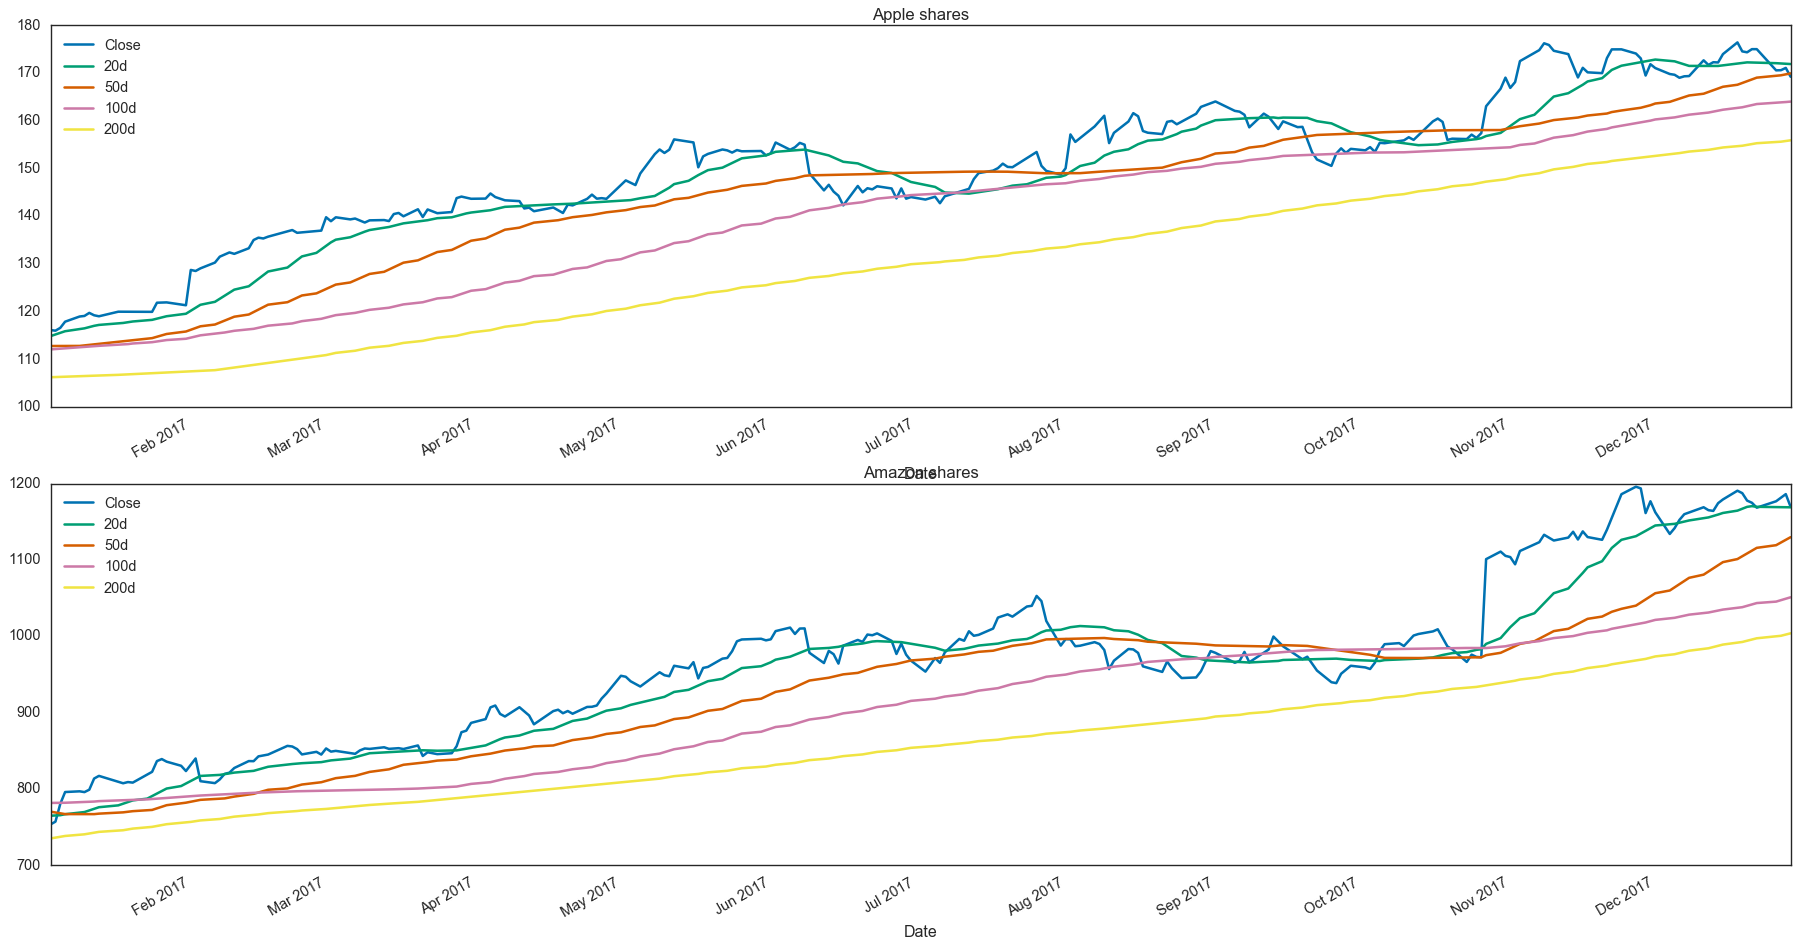

In [71]:
fig, axes = plt.subplots(2,1,figsize=(25, 15))
axes[0].set_title('Apple shares',fontsize = 15)
axes[1].set_title('Amazon shares',fontsize = 15)
AAPL.loc['2017-01-01':,].drop(['Volume','High','Low','Open'],axis=1).plot(ax = axes[0])
AMZN.loc['2017-01-01':,].drop(['Volume','High','Low','Open'],axis=1).plot(ax = axes[1])

# AAPL.drop(['Volume','High','Low','Open'],axis=1).plot(ax = axes[0])
# AMZN.drop(['Volume','High','Low','Open'],axis=1).plot(ax = axes[1])

plt.show()



## Question 4. Take five stocks of your choice and create the same type of report stated in question 3

## Question 4 Report

- We will start by selection 5 out of the total 31 stocks from the list of tickers. There are reasearch indicating that most stocks behave in similar manner and that behavior is a funciton of the overall market trens. We need to compare the correlating between market stock to test this hypothesis

```python
Stockfive = all[all.Name.isin(['GE','IBM','WMT','GOOGL','NKE'])]
Stockfive['Date'] = pd.to_datetime(Stockfive.Date)
# Stockfive.head(1000)
Stockfive = Stockfive.pivot(index = 'Date' , columns = 'Name', values = 'Open')
Stockfive_returns = Stockfive.pct_change()
cov_matrix_d = Stockfive_returns.cov()
cov_matrix_a = cov_matrix_d * 250 # 250 trading days
fig = plt.figure(figsize = (7,7))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(Stockfive.corr(),cmap = cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
```
<img src="Q5corr.png">
- Next we plot the time series for all the 5 for all the shares and to look at their recent trends

```python
Stockfive = Stockfive.rename_axis(None,axis=1).reset_index()
Stockfive['Date'] = pd.to_datetime(Stockfive.Date)
Stockfive = Stockfive.set_index('Date')
fig,ax = plt.subplots(figsize=(15,5))
Stockfive.drop(['GOOGL'],axis=1).plot(ax=ax, lw = 0.5)
Stockfive[['GOOGL']].plot(ax=ax,secondary_y = True, lw = 0.5)

```
<img src="Q5trend.png">

- Before we move on to understand the profitibility of these share we should look at the fast and slow moving averages

```python
# Rolling averages for all stocks
fig,ax = plt.subplots(3,2,figsize=(20,20))
Stockfive.loc['2017-01-01':,['GOOGL','GOOGL20d','GOOGL50d','GOOGL100d','GOOGL200d']].plot(ax=ax[0,0],legend = True)
Stockfive.loc['2017-01-01':,['IBM','IBM20d','IBM50d','IBM100d','IBM200d']].plot(ax=ax[0,1],legend = True)
Stockfive.loc['2017-01-01':,['GE','GE20d','GE50d','GE100d','GE200d']].plot(ax=ax[1,0],legend = True)
Stockfive.loc['2017-01-01':,['NKE','NKEL20d','NKE50d','NKE100d','NKE200d']].plot(ax=ax[1,1],legend = True)
Stockfive.loc['2017-01-01':,['WMT','WMT20d','WMT50d','WMT100d','WMT200d']].plot(ax=ax[2,0],legend = True)
fig.delaxes(ax[2,1])
plt.show()
```
<img src="Q5moving.png">

- Moving forward we wanted to look at the recent daily returns for all the share to analyze the ROI

```python
fig,ax = plt.subplots(3,2,figsize=(20,20))
fig.suptitle('Trend for market return(last 1 year) for all 5 stoks', fontsize=16)
Stockfive_returns['GOOGL'].loc['2017-01-01':,].plot(ax=ax[0,0],color = 'r',legend = True).axhline(y = 0, color = "black", lw = 2)
Stockfive_returns['GE'].loc['2017-01-01':,].plot(ax=ax[0,1],color = 'g',legend = True).axhline(y = 0, color = "black", lw = 2)
Stockfive_returns['IBM'].loc['2017-01-01':,].plot(ax=ax[1,0],color = 'y',legend = True).axhline(y = 0, color = "black", lw = 2)
Stockfive_returns['NKE'].loc['2017-01-01':,].plot(ax=ax[1,1],color = 'c',legend = True).axhline(y = 0, color = "black", lw = 2)
Stockfive_returns['WMT'].loc['2017-01-01':,].plot(ax=ax[2,0],color = 'm',legend = True).axhline(y = 0, color = "black", lw = 2)
fig.delaxes(ax[2,1])
```
<img src="Q5Growth.png">

- As state in q2, we should use candle stick diagraphs to combine all availabe information about the stocks in one visualisation to get better insights about the stock performance

```python
fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,figsize=(20,20))
ax = pandas_candlestick_ohlc(IBM.loc['2017-01-01':,],fig=fig,ax=ax1,adj=False, stick="month")
ax = pandas_candlestick_ohlc(GE.loc['2017-01-01':,],fig=fig,ax=ax2,adj=False, stick="month")
ax = pandas_candlestick_ohlc(NKE.loc['2017-01-01':,],fig=fig,ax=ax3,adj=False, stick="month")
ax = pandas_candlestick_ohlc(WMT.loc['2017-01-01':,],fig=fig,ax=ax4,adj=False, stick="month")
ax = pandas_candlestick_ohlc(GOOGL.loc['2017-01-01':,],fig=fig,ax=ax5,adj=False, stick="month")
```
<img src="Q5Candle.png">

## Question 4 Analysis

In [140]:
#selecting 5 random shares
Stockfive = all[all.Name.isin(['GE','IBM','WMT','GOOGL','NKE'])]
Stockfive['Date'] = pd.to_datetime(Stockfive.Date)
# Stockfive.head(1000)
Stockfive = Stockfive.pivot(index = 'Date' , columns = 'Name', values = 'Open')
Stockfive_returns = Stockfive.pct_change()
cov_matrix_d = Stockfive_returns.cov()
cov_matrix_a = cov_matrix_d * 250
# cov_matrix_a

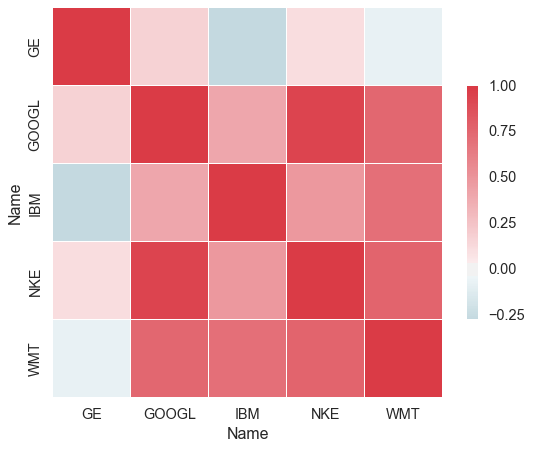

In [141]:
#correlation plot
fig = plt.figure(figsize = (7,7))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(Stockfive.corr(),cmap = cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [142]:
# datetime index
Stockfive = Stockfive.rename_axis(None,axis=1).reset_index()
Stockfive['Date'] = pd.to_datetime(Stockfive.Date)
Stockfive = Stockfive.set_index('Date')
# Stockfive = Stockfive.fillna(0)

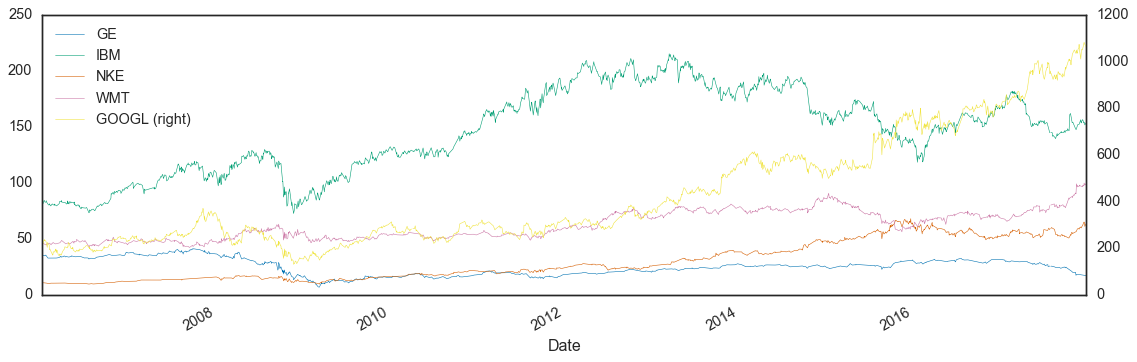

In [143]:
fig,ax = plt.subplots(figsize=(15,5))

Stockfive.drop(['GOOGL'],axis=1).plot(ax=ax, lw = 0.5)
Stockfive[['GOOGL']].plot(ax=ax,secondary_y = True, lw = 0.5)

In [144]:
#Calculating moving averages for all shares
ll = ['IBM','GOOGL','WMT','NKE','GE']
for files in ll:
    name = files
    exec('Stockfive[\'{}20d\'] = np.round(Stockfive[\'{}\'].rolling(window = 20, center = False,min_periods = 1).mean(), 2)'.format(name,name))
    exec('Stockfive[\'{}50d\'] = np.round(Stockfive[\'{}\'].rolling(window = 50, center = False,min_periods = 1).mean(), 2)'.format(name,name))
    exec('Stockfive[\'{}100d\'] = np.round(Stockfive[\'{}\'].rolling(window = 100, center = False,min_periods = 1).mean(), 2)'.format(name,name))
    exec('Stockfive[\'{}200d\'] = np.round(Stockfive[\'{}\'].rolling(window = 200, center = False,min_periods = 1).mean(), 2)'.format(name,name))


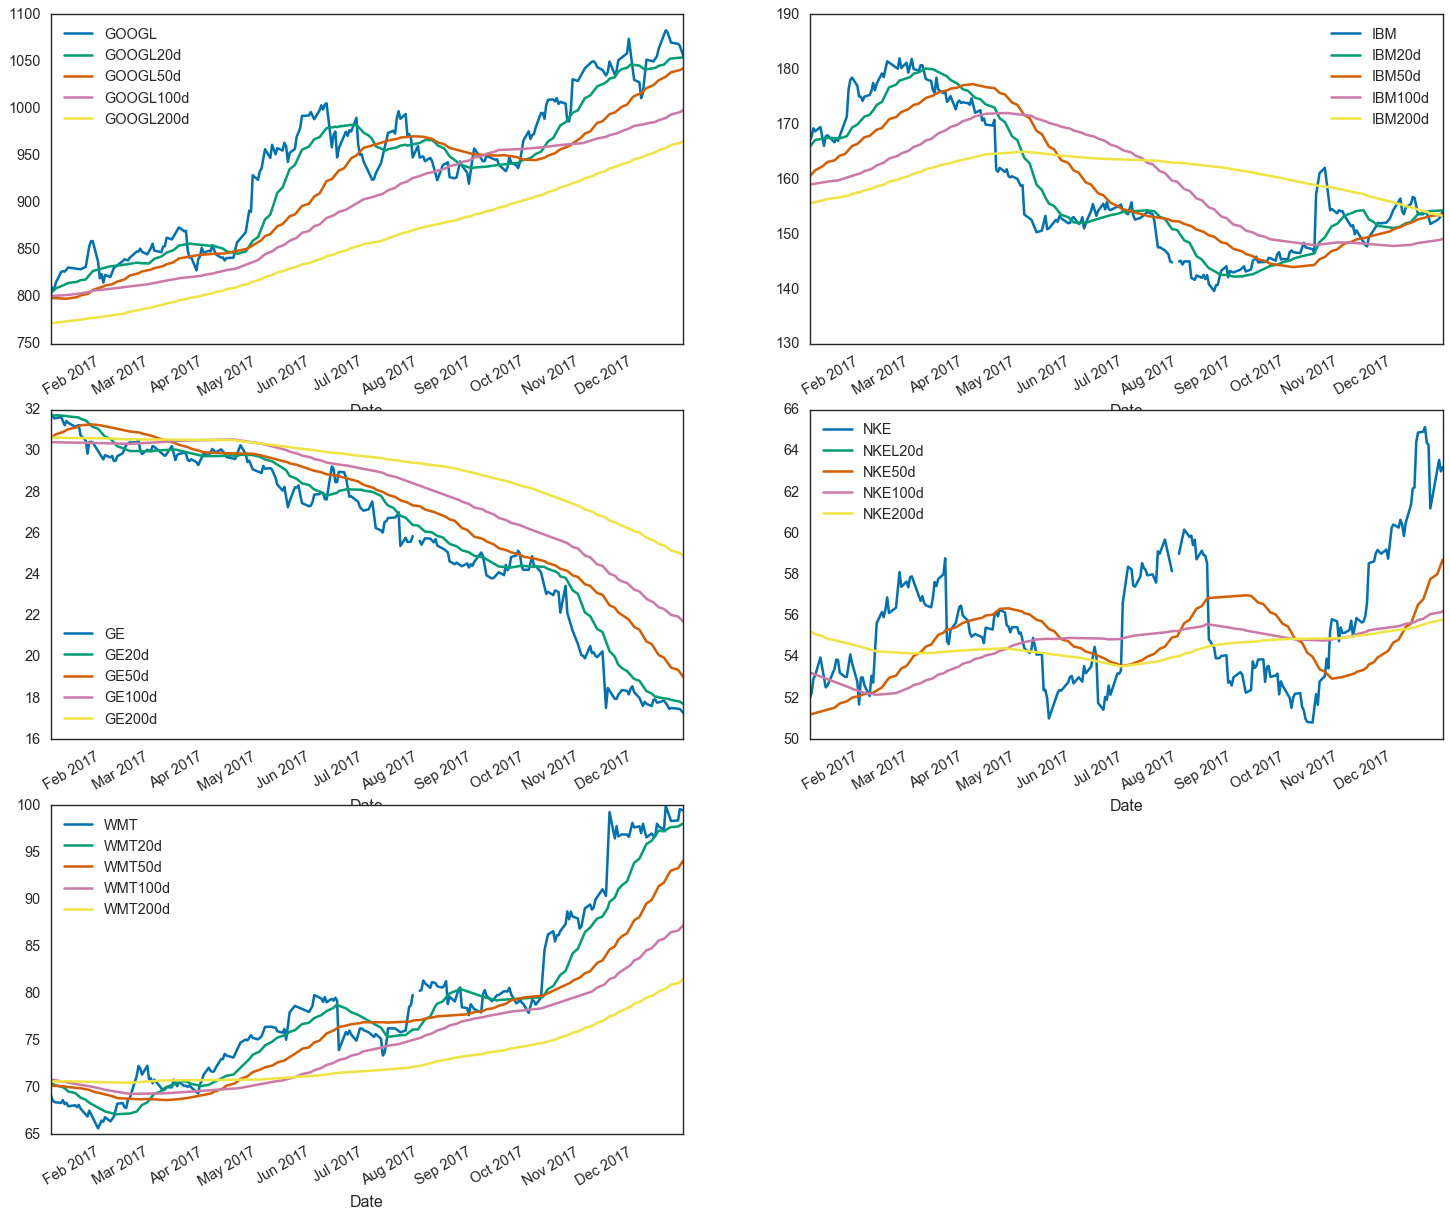

In [145]:
# Rolling averages for all stocks
fig,ax = plt.subplots(3,2,figsize=(20,20))
Stockfive.loc['2017-01-01':,['GOOGL','GOOGL20d','GOOGL50d','GOOGL100d','GOOGL200d']].plot(ax=ax[0,0],legend = True)
Stockfive.loc['2017-01-01':,['IBM','IBM20d','IBM50d','IBM100d','IBM200d']].plot(ax=ax[0,1],legend = True)
Stockfive.loc['2017-01-01':,['GE','GE20d','GE50d','GE100d','GE200d']].plot(ax=ax[1,0],legend = True)
Stockfive.loc['2017-01-01':,['NKE','NKEL20d','NKE50d','NKE100d','NKE200d']].plot(ax=ax[1,1],legend = True)
Stockfive.loc['2017-01-01':,['WMT','WMT20d','WMT50d','WMT100d','WMT200d']].plot(ax=ax[2,0],legend = True)
fig.delaxes(ax[2,1])
plt.show()

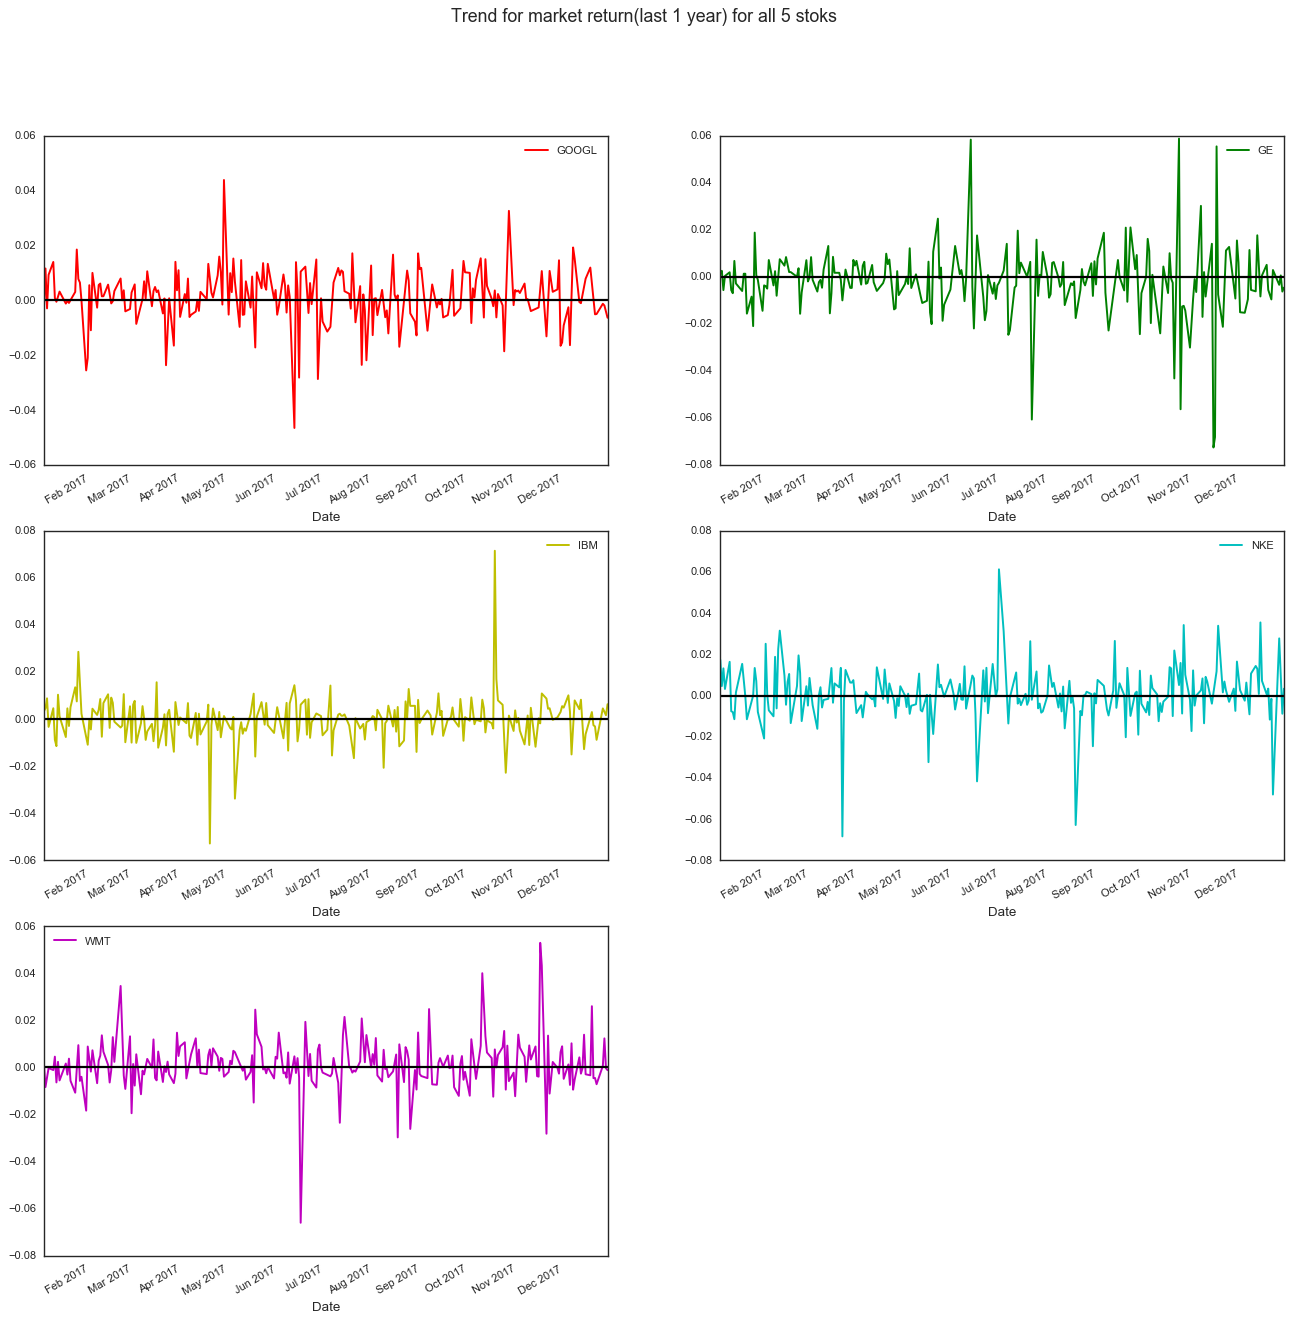

In [50]:
fig,ax = plt.subplots(3,2,figsize=(20,20))
fig.suptitle('Trend for market return(last 1 year) for all 5 stoks', fontsize=16)

Stockfive_returns['GOOGL'].loc['2017-01-01':,].plot(ax=ax[0,0],color = 'r',legend = True).axhline(y = 0, color = "black", lw = 2)
Stockfive_returns['GE'].loc['2017-01-01':,].plot(ax=ax[0,1],color = 'g',legend = True).axhline(y = 0, color = "black", lw = 2)
Stockfive_returns['IBM'].loc['2017-01-01':,].plot(ax=ax[1,0],color = 'y',legend = True).axhline(y = 0, color = "black", lw = 2)
Stockfive_returns['NKE'].loc['2017-01-01':,].plot(ax=ax[1,1],color = 'c',legend = True).axhline(y = 0, color = "black", lw = 2)
Stockfive_returns['WMT'].loc['2017-01-01':,].plot(ax=ax[2,0],color = 'm',legend = True).axhline(y = 0, color = "black", lw = 2)
fig.delaxes(ax[2,1])
# Stockfive_returns.loc['2017-09-01':,].plot(ax=inset_ret,legend = False)


In [51]:
#seting datetime index
ll = ['IBM','GOOGL','WMT','NKE','GE']

for files in ll:
    name = files
#     print(name)
    exec('{}[\'Date\'] = pd.to_datetime({}.Date)'.format(name,name))
    exec('{} = {}.set_index(\'Date\')'.format(name,name))


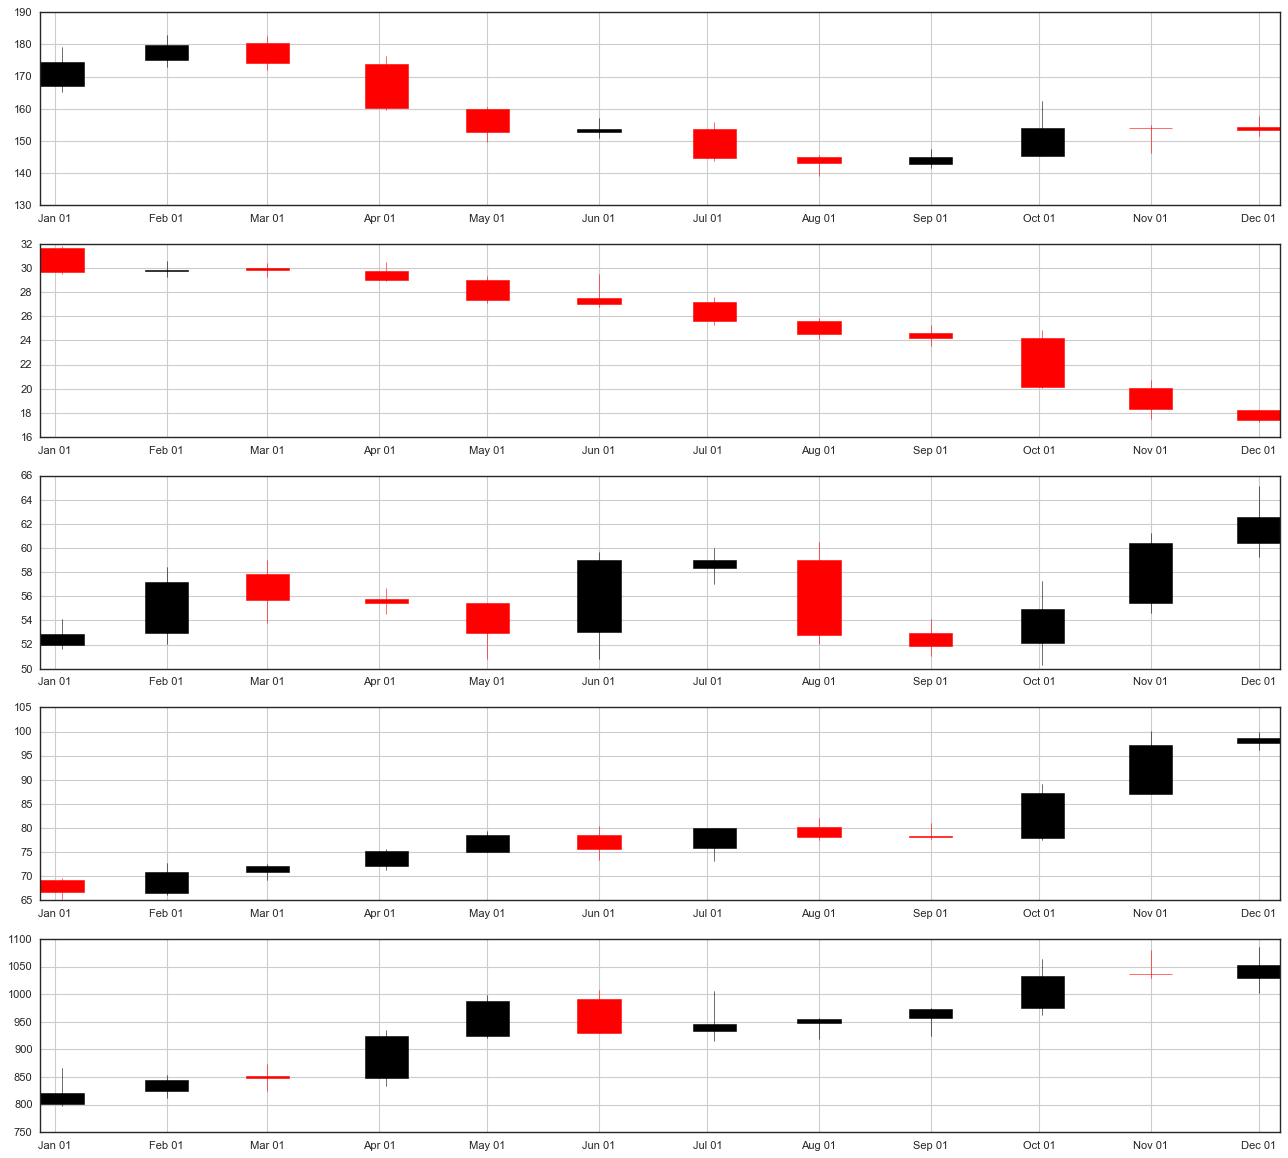

In [52]:
# candle stick visualization
fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,figsize=(20,20))

# ax1.set_title('Apple shares',fontsize = 50)
# ax2.set_title('Amazon shares',fontsize = 50)


# ax2.title.set_text('Amazon Share',fontsize=15)
ax = pandas_candlestick_ohlc(IBM.loc['2017-01-01':,],fig=fig,ax=ax1,adj=False, stick="month")
ax = pandas_candlestick_ohlc(GE.loc['2017-01-01':,],fig=fig,ax=ax2,adj=False, stick="month")
ax = pandas_candlestick_ohlc(NKE.loc['2017-01-01':,],fig=fig,ax=ax3,adj=False, stick="month")
ax = pandas_candlestick_ohlc(WMT.loc['2017-01-01':,],fig=fig,ax=ax4,adj=False, stick="month")
ax = pandas_candlestick_ohlc(GOOGL.loc['2017-01-01':,],fig=fig,ax=ax5,adj=False, stick="month")
# fig.delaxes(ax[2,1])
# plt.legend()
# plt.show()